<a href="https://colab.research.google.com/github/SerafinCarba/programacion-de-incorporaciones-/blob/master/Ejercicio_de_programaci%C3%B3n_de_incorporaciones_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Introducción a los datos dispersos y las incorporaciones

**Objetivos de aprendizaje:**
* convertir datos de strings de reseñas de películas en un vector de atributos dispersos
* implementar un modelo lineal de análisis de opiniones a través de un vector de atributos dispersos
* implementar un modelo de RNP de análisis de opiniones a través de una incorporación que proyecte datos en dos dimensiones
* visualizar la incorporación para observar qué aprendió el modelo acerca de las relaciones entre las palabras

En este ejercicio, exploraremos datos dispersos y trabajaremos con incorporaciones mediante el uso de datos de texto de reseñas de películas (del [conjunto de datos de IMDB de ACL 2011](http://ai.stanford.edu/~amaas/data/sentiment/). Estos datos ya se procesaron en formato `tf.Example`.  

 ## Preparación

Importemos nuestras dependencias y descarguemos los datos de entrenamiento y de prueba. [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) incluye una herramienta de almacenamiento en caché y descarga de archivos que podemos usar para recuperar los conjuntos de datos.

In [0]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

 ## Desarrollo de un modelo de análisis de opiniones

 Entrenemos un modelo de análisis de opiniones con estos datos, que prediga si una reseña es en general *favorable* (etiqueta de 1) o *desfavorable* (etiqueta de 0).

Para eso, convertiremos nuestros `terms` con valores de strings en vectores de atributos a través de un *vocabulario*, una lista de cada término que esperamos ver en nuestros datos. Para los fines de este ejercicio, creamos un pequeño vocabulario que se enfoca en un conjunto de términos limitado. La mayoría de estos se consideraron fuertes indicadores de *favorable* o *unfavorable*, pero algunos se agregaron simplemente porque son interesantes.

Cada término del vocabulario está asignado a una coordenada de nuestro vector de atributos. Para convertir los `terms` con valores de strings para un ejemplo en este formato de vector, los codificamos de manera tal que cada coordenada obtenga un valor de 0 si el término del vocabulario no aparece en la string de ejemplo y un valor de 1 si aparece. Los términos de un ejemplo que no aparecen en el vocabulario se descartan.

 **NOTA:** *Desde luego, podríamos usar un vocabulario más grande. También existen herramientas especiales para crearlos. Además, en lugar de simplemente descartar los términos que no están en el vocabulario, podemos incorporar una pequeña cantidad de agrupamientos OOV (fuera de vocabulario), con los cuales se puede generar un hash para los términos que no están en el vocabulario. A su vez, podemos usar un enfoque de __generación de hashes de atributos__ que genere hashes de cada término, en lugar de crear un vocabulario explícito. Esto funciona bien en la práctica, pero dificulta la interpretabilidad, que es útil para este ejercicio. Consulta el módulo tf.feature_column para obtener herramientas para abordar esto.*

 ## Desarrollo de la canalización de entrada

 Primero, configuremos la canalización de entrada para importar nuestros datos a un modelo de TensorFlow. Podemos usar la siguiente función para analizar los datos de entrenamiento y de prueba (que se encuentran en formato [TFRecord](https://www.tensorflow.org/guide/datasets#consuming_tfrecord_data)) y devolver un diccionario de los atributos y etiquetas correspondientes.

In [0]:
def _parse_function(record):
  """Extracts features and labels.
  
  Args:
    record: File path to a TFRecord file    
  Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']

  return  {'terms':terms}, labels

 Para confirmar que nuestra función se desempeña de acuerdo con lo esperado, construyamos un `TFRecordDataset` para los datos de entrenamiento y asignemos los datos a atributos y etiquetas a través del atributo que se incluyó más arriba.

In [0]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<DatasetV1Adapter shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

 Ejecuta la siguiente celda para recuperar el primer ejemplo del conjunto de datos de entrenamiento.

In [0]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

 Ahora, desarrollemos una función de entrada formal que podamos pasar al método `train()` de un objeto de Estimator de TensorFlow.

In [0]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
  # Same code as above; create a dataset and map features and labels.
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary.     
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

 ## Tarea 1: Usar un modelo lineal con entradas dispersas y vocabulario explícito

Para nuestro primer modelo, desarrollaremos un modelo de [`LinearClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) con 50 términos informativos; siempre debemos comenzar por lo más simple.

El siguiente código genera la columna de atributos para nuestros términos. El atributo [`categorical_column_with_vocabulary_list`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list) crea una columna de funciones con la asignación de string a vector de funciones.

In [0]:
# 50 informative terms that compose our model vocabulary. 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

 A continuación, generaremos el `LinearClassifier`, lo entrenaremos con el conjunto de entrenamiento y lo evaluaremos con el conjunto de evaluación. Después de leer todo el código, ejecútalo y observa el desempeño.

In [0]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78876
accuracy_baseline 0.5
auc 0.8718128
auc_precision_recall 0.8626489
average_loss 0.45086613
label/mean 0.5
loss 11.271653
precision 0.7631406
prediction/mean 0.5071384
recall 0.83744
global_step 1000
---
Test set metrics:
accuracy 0.7838
accuracy_baseline 0.5
auc 0.86987597
auc_precision_recall 0.86030877
average_loss 0.45201382
label/mean 0.5
loss 11.300345
precision 0.75979495
prediction/mean 0.50543594
recall 0.83
global_step 1000
---


 ## Tarea 2: Usar un modelo de redes neuronales profundas (RNP)

El modelo anterior es un modelo lineal que funciona bastante bien. Pero, ¿podemos obtener un mejor desempeño con un modelo de RNP?

Cambiemos a un [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) en lugar del `LinearClassifier`. Ejecuta la siguiente celda y observa qué desempeño obtienes.

In [0]:
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                                                                             #
###############################################################################

try:
  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
accuracy 0.76
accuracy_baseline 0.64
auc 0.9374999
auc_precision_recall 0.96455777
average_loss 0.37442017
label/mean 0.64
loss 9.360504
precision 0.9166667
prediction/mean 0.5024548
recall 0.6875
global_step 1000
---
Test set metrics:
accuracy 0.92
accuracy_baseline 0.52
auc 0.99999994
auc_precision_recall 0.9999999
average_loss 0.22010092
label/mean 0.48
loss 5.502523
precision 0.85714287
prediction/mean 0.49469692
recall 1.0
global_step 1000
---


 ## Tarea 3: Usar una incorporación con un modelo de RNP

En esta tarea, implementaremos nuestro modelo de RNP mediante el uso de una columna de incorporaciones. Una columna de incorporaciones toma datos dispersos como entrada y devuelve un vector denso de dimensiones más bajas como resultado.

 **NOTA:** *Una embedding_column suele ser la opción más eficaz con relación al cómputo que se puede usar para entrenar un modelo con datos dispersos. En una [sección opcional](#scrollTo=XDMlGgRfKSVz) al final de este ejercicio, analizaremos en más detalle las diferencias de implementación entre el uso de una `embedding_column` y una `indicator_column`, así como las ventajas y desventajas de seleccionar una o la otra.*

 En el siguiente código, realiza lo siguiente:

* Define las columnas de atributos para el modelo a través de una `embedding_column` que proyecte los datos en 2 dimensiones (para obtener más detalles sobre la firma de funciones para `embedding_column`, consulta la [documentación de TF](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column)).
* Define un `DNNClassifier` con las siguientes especificaciones:
  * Dos capas ocultas de 20 unidades cada una
  * Optimización de AdaGrad con una tasa de aprendizaje de 0.1
  * Una `gradient_clip_norm` de 5.0

 **NOTA:** *En la práctica, es posible que proyectemos en más que 2 dimensiones, como 50 o 100. Pero, por ahora, 2 dimensiones son fáciles de visualizar.*

 ### Sugerencia

In [0]:
# Here's a example code snippet you might use to define the feature columns:

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

 ### Completa el código a continuación

In [0]:
########################## YOUR CODE HERE ######################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer
)

################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.787
accuracy_baseline 0.5
auc 0.8687801
auc_precision_recall 0.85734653
average_loss 0.45379445
label/mean 0.5
loss 11.344861
precision 0.7602844
prediction/mean 0.5216456
recall 0.83832
global_step 1000
---
Test set metrics:
accuracy 0.78484
accuracy_baseline 0.5
auc 0.86787605
auc_precision_recall 0.8555139
average_loss 0.45518923
label/mean 0.5
loss 11.37973
precision 0.76017535
prediction/mean 0.52049893
recall 0.83224
global_step 1000
---


 ### Solución

Haz clic más abajo para conocer la solución.

In [0]:
########################## SOLUTION CODE ########################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer
)
#################################################################################

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

 ## Tarea 4: Convencerte de que realmente hay una incorporación allí

El modelo anterior utilizó una `embedding_column` y pareció tener un buen desempeño, pero esto no nos indica mucho qué ocurre internamente. ¿Cómo podemos comprobar que el modelo realmente está usando una incorporación dentro?

Para comenzar, observemos los tensores del modelo:

In [0]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

 Bien, podemos observar que hay una capa de incorporaciones allí: `'dnn/input_from_feature_columns/input_layer/terms_embedding/...'`. (De hecho, lo interesante aquí es que esta capa se puede entrenar junto con el resto del modelo, al igual que cualquier capa oculta).

¿La capa de incorporaciones tiene la forma correcta? Ejecuta el siguiente código para descubrirlo.

 **NOTA:** *Recuerda que, en nuestro caso, la incorporación es una matriz que nos permite proyectar un vector de 50 dimensiones en 2 dimensiones.*

In [0]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

 Dedica un tiempo a comprobar manualmente las diferentes capas y formas a fin de asegurarte de que todo esté conectado según lo esperado.

 ## Tarea 5: Examinar la incorporación

Ahora observemos el espacio de incorporación real y veamos dónde acaban los términos dentro de este. Realiza lo siguiente:
1. Ejecuta el código que aparece a continuación para ver la incorporación que entrenamos en la **Tarea 3**. ¿Los términos están donde esperabas?

2. Ejecutar el código de la **Tarea 3** otra vez para volver a entrenar el modelo y, luego, vuelve a ejecutar la visualización de la incorporación que aparece más abajo. ¿Qué permanece igual? ¿Qué cambia?

3. Finalmente, vuelve a entrenar el modelo con solo 10 pasos (lo cual producirá un modelo terrible). Vuelve a ejecutar la visualización de la incorporación que aparece más abajo. ¿Qué ves ahora y por qué?

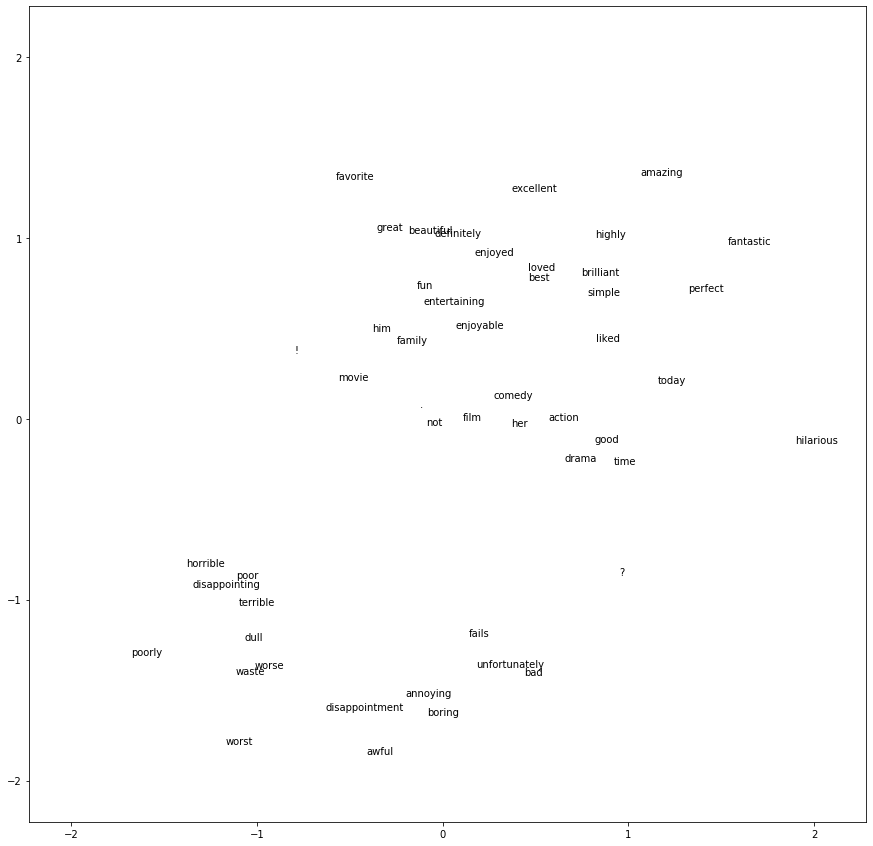

In [0]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term.  It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

 ## Tarea 6: Intentar mejorar el rendimiento del modelo

Ve si puedes ajustar el modelo para mejorar el rendimiento. A continuación, se indican algunas acciones que puedes probar:

* **Cambiar los hiperparámetros** o **usar un optimizador diferente**, como Adam (es posible que solo ganes uno o dos puntos en el porcentaje de exactitud con estas estrategias).
* **Agregar términos adicionales a `informative_terms`.** Hay un archivo de vocabulario completo con los 30,716 términos para este conjunto de datos que puedes usar en https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt. Puedes seleccionar términos adicionales de este archivo de vocabulario o usar el archivo completo a través de la columna de atributos `categorical_column_with_vocabulary_file`.

In [0]:
# Download the vocabulary file.
terms_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

In [0]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  # Convert it to a set first to remove duplicates.
  informative_terms = list(set(f.read().split()))
  
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.82868
accuracy_baseline 0.5
auc 0.9047747
auc_precision_recall 0.9015274
average_loss 0.3924855
label/mean 0.5
loss 9.812138
precision 0.8271359
prediction/mean 0.50346386
recall 0.83104
global_step 1000
---
Test set metrics:
accuracy 0.81316
accuracy_baseline 0.5
auc 0.89116323
auc_precision_recall 0.8876822
average_loss 0.4174576
label/mean 0.5
loss 10.43644
precision 0.8160678
prediction/mean 0.50052893
recall 0.80856
global_step 1000
---


 ## Conclusión

Es posible que hayamos obtenido una solución de RNP con una incorporación que se desempeñó mejor que nuestro modelo lineal original, pero el modelo lineal también era bastante bueno y algo más rápido para entrenar. Los modelos lineales se entrenan más rápidamente porque no tienen tantos parámetros para actualizar o capas para realizar propagación inversa.

En algunas aplicaciones, la velocidad de los modelos lineales puede cambiar las reglas del juego. A veces, los modelos lineales pueden ser muy convenientes desde el punto de vista de la calidad. Y en otras áreas, la complejidad adicional del modelo y la capacidad proporcionada por las RNP puede ser más importante. Al definir la arquitectura del modelo, recuerda explorar tu problema lo suficiente como para saber en qué espacio te encuentras.

 ### *Análisis opcional:* Ventajas y desventajas entre `embedding_column` y `indicator_column`

A nivel conceptual, cuando entrenamos un `LinearClassifier` o un `DNNClassifier`, necesitamos una adaptación para usar una columna dispersa. TF ofrece dos opciones: `embedding_column` o `indicator_column`.

Al entrenar un clasificador lineal (como en la **Tarea 1**), se usa una `embedding_column` como opción avanzada. Como se ve en la **Tarea 2**, al entrenar un `DNNClassifier`, debes elegir explícitamente `embedding_column` o `indicator_column`. En esta sección, se observa un ejemplo simple para analizar la diferencia entre ambas, así como las ventajas y desventajas de usar una o la otra.

 Imagina que tenemos datos dispersos que contienen los valores `"great"`, `"beautiful"` y `"excellent"`. Dado que el tamaño del vocabulario que estamos usando aquí es de $V = 50$, cada unidad (neurona) de la primera capa tendrá 50 ponderaciones. Denotamos el número de términos de una entrada dispersa mediante el uso de $s$. Por lo tanto, para los datos dispersos de este ejemplo, $s = 3$. Para una capa de entrada con $V$ valores posibles, una capa oculta con $d$ unidades debe hacer una multiplicación de vector por matriz: $(1 \times V) * (V \times d)$. Esto tiene un costo de cómputo de $O(V * d)$. Ten en cuenta que este costo es proporcional al número de ponderaciones en una capa oculta e independiente de $s$.

Si las entradas tienen codificación de un solo 1 (un vector booleano con una longitud de $V$ con un 1 para los términos presentes y un 0 para el resto) que usa una [`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column), esto significa multiplicar y sumar muchos ceros.

 Cuando logramos exactamente los mismos resultados al usar una [`embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column) con un tamaño de $d$, buscamos y sumamos solamente aquellas incorporaciones correspondientes a las tres atributos presentes en la entrada de nuestro ejemplo de `"great"`, `"beautiful"` y `"excellent"`: $(1 \times d) + (1 \times d) + (1 \times d)$. Dado que las ponderaciones de los atributos que están ausentes se multiplican por cero en la multiplicación de vector por matriz, estas no contribuyen al resultado. Las ponderaciones de los atributos que están presentes se multiplican por 1 en la multiplicación de vector por matriz. Por lo tanto, al sumar las ponderaciones obtenidas a través de la búsqueda de incorporaciones, se obtendrá el mismo resultado que en la multiplicación de vector por matriz.

Al usar una incorporación, el cómputo de la búsqueda de incorporaciones es un cómputo de $O(s * d)$, el cual es mucho más eficiente con relación al cómputo que el costo de $O(V * d)$ para la `indicator_column` en datos dispersos, para los cuales $s$ es mucho más pequeño que $V$. (Recuerda que estas incorporaciones se están aprendiendo. En cualquier iteración de entrenamiento dada, las ponderaciones actuales son las que se buscan.)

 Como vimos en la **Tarea 3**, al usar una `embedding_column` al entrenar el `DNNClassifier`, nuestro modelo aprende una representación de dimensiones bajas para los atributos, en la que el producto de puntos define una métrica de similitud adaptada a la tarea deseada. En este ejemplo, los términos que se usan de manera similar en el contexto de las reseñas de películas (p. ej., `"great"` y `"excellent"`) estarán más cerca entre sí en el espacio de incorporación (es decir, tendrán un producto de puntos de gran tamaño) y los términos que son desemejantes (p. ej., `"great"` y `"bad"`) estarán más alejados entre sí en el espacio de incorporación (es decir, tendrán un producto de puntos pequeño).